# mount drive

In [39]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

KeyboardInterrupt: ignored

In [ ]:
# import packages
import datetime
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [ ]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [ ]:
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data["time"])

In [ ]:
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday

In [ ]:
ld_col = ["x", "y", "direction"]

weekday_mean = data.iloc[:len(train)].groupby(ld_col + ["weekday"]).congestion.mean()
hour_mean = data.iloc[:len(train)].groupby(ld_col + ["hour"]).congestion.mean()
minute_mean = data.iloc[:len(train)].groupby(ld_col + ["minute"]).congestion.mean()

weekday_mean.colmuns = ["weekday_mean"]
hour_mean.colmuns = ["hour_mean"]
minute_mean.columns = ["minute_mean"]

data = data.merge(weekday_mean, how="left", left_on=ld_col+["weekday"], right_index=True, suffixes=("", "_weekday_mean"))
data = data.merge(hour_mean, how="left", left_on=ld_col+["hour"], right_index=True, suffixes=("", "_hour_mean"))
data = data.merge(minute_mean, how="left", left_on=ld_col+["minute"], right_index=True, suffixes=("", "_minute_mean"))
data.head()

In [ ]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [ ]:
xs = train.x.unique().tolist()
ys = train.y.unique().tolist()
dirs = train.direction.unique().tolist()

feature_col = ["hour", "minute", "weekday", "congestion_weekday_mean", "congestion_hour_mean", "congestion_minute_mean"]

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

oof_train = np.zeros((len(train), ))
oof_idx = []
all_models = {}
all_y_preds = {}

for x in xs:
    for y in ys:
        for dir in dirs:
            loc_dir = (x, y, dir)
            print("======== loop: {} ========".format(loc_dir))

            locdir_X_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)][feature_col]
            locdir_y_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)]["congestion"]
            locdir_X_test = test[(test.x == x) & (test.y == y) & (test.direction == dir)][feature_col]

            # loc & dir の組み合わせが存在しないときは処理しない
            if locdir_X_train.shape[0] == 0:
                print("{} is nothing".format(loc_dir))
                continue

            cv = TimeSeriesSplit(n_splits=5)

            y_preds = []
            models = []

            for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(locdir_X_train)):
                print(f"======== fold: {fold_idx} ========")
                X_tr, X_val = locdir_X_train.iloc[tr_idx], locdir_X_train.iloc[val_idx]
                y_tr, y_val = locdir_y_train.iloc[tr_idx], locdir_y_train.iloc[val_idx]
                
                lgb_train = lgb.Dataset(X_tr, y_tr)
                lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
                
                model = lgb.train(params, lgb_train,
                                valid_sets=[lgb_train, lgb_eval],
                                verbose_eval=10,
                                num_boost_round=1000,
                                early_stopping_rounds=10)
                
                oof_train[X_val.index] = \
                    model.predict(X_val, num_iteration=model.best_iteration)

                oof_idx += X_val.index.tolist()

                y_pred = model.predict(locdir_X_test, num_iteration=model.best_iteration)

                y_preds.append(y_pred)
                models.append(model)
            
            all_y_preds[loc_dir] = y_preds
            all_models[loc_dir] = models

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[oof_idx], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[oof_idx].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()

In [ ]:
scores = {}

for ld, ms in all_models.items():
    scores[ld] = ms[-1].best_score["valid_1"]["l1"]

score = sum(scores.values()) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

In [ ]:
with open("../output/all_y_preds_007.pickle", "wb") as f:
    pickle.dump(all_y_preds, f)

with open("../output/all_models_007.pickle", "wb") as f:
    pickle.dump(all_models, f)

with open("../output/oof_train_007.pickle", "wb") as f:
    pickle.dump(oof_train, f)

with open("../output/oof_idx_007.pickle", "wb") as f:
    pickle.dump(oof_idx, f)

In [ ]:
sub_pred = test.copy()[["x", "y", "direction", "congestion"]]

In [ ]:
for (x, y, dir), y_preds in all_y_preds.items():
    sub_pred.loc[((test.x == x) & (test.y == y) & (test.direction == dir)), ["congestion"]] = y_preds[-1]

In [ ]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = sub_pred.congestion.to_numpy()
submission.to_csv("../submit/submission_007.csv", index=False)

===========(0, 0, 'EB')===========


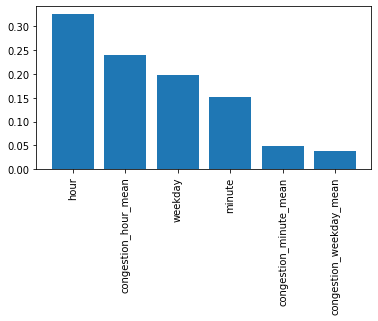

===========(0, 0, 'NB')===========


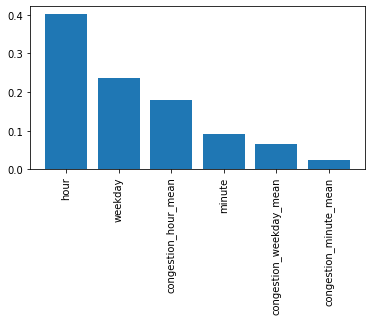

===========(0, 0, 'SB')===========


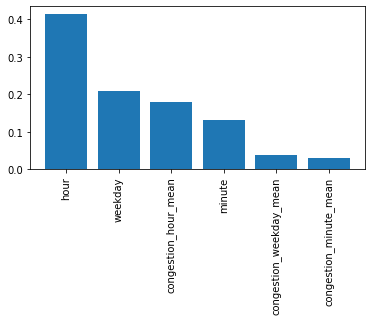

===========(0, 1, 'EB')===========


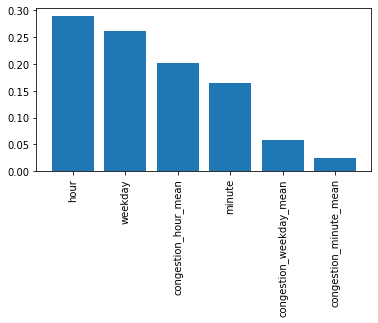

===========(0, 1, 'NB')===========


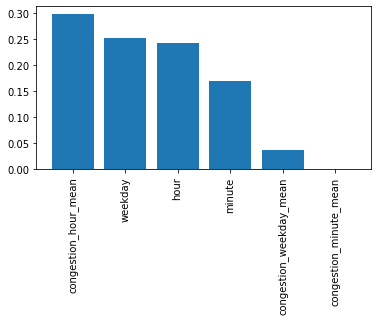

===========(0, 1, 'SB')===========


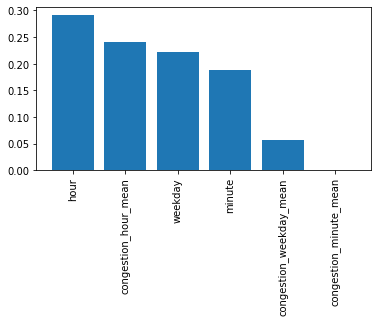

===========(0, 1, 'WB')===========


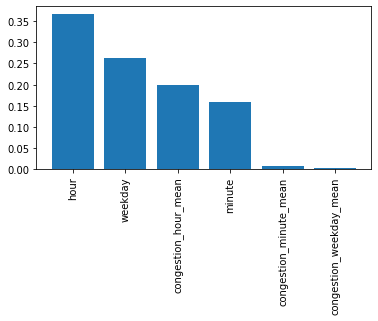

===========(0, 2, 'EB')===========


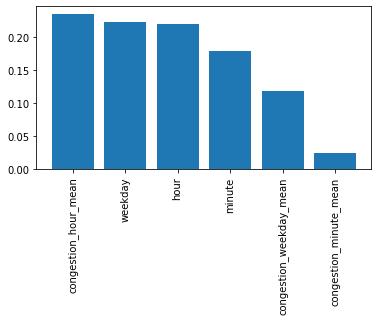

===========(0, 2, 'NB')===========


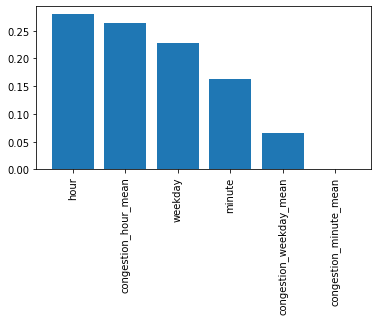

===========(0, 2, 'SB')===========


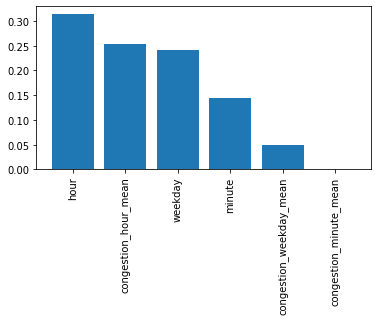

===========(0, 2, 'WB')===========


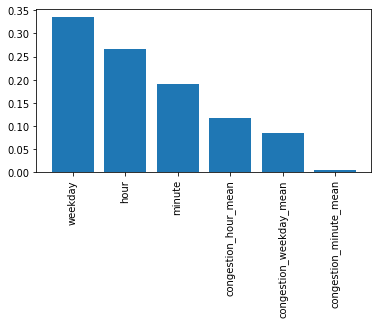

===========(0, 3, 'EB')===========


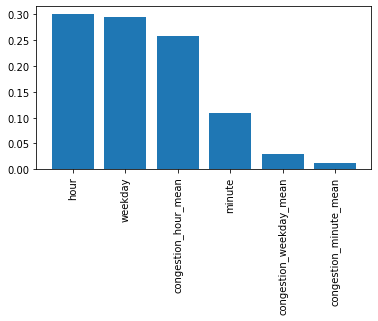

===========(0, 3, 'NB')===========


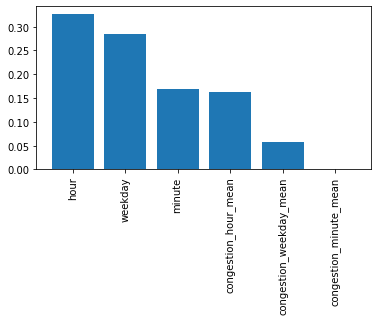

===========(0, 3, 'SB')===========


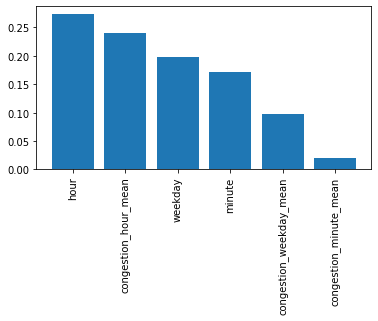

===========(0, 3, 'WB')===========


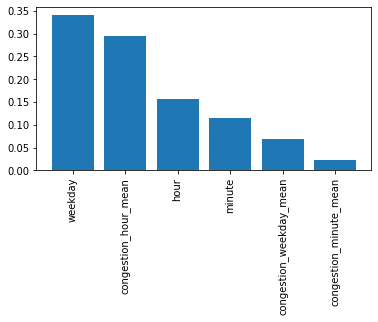

===========(0, 3, 'NE')===========


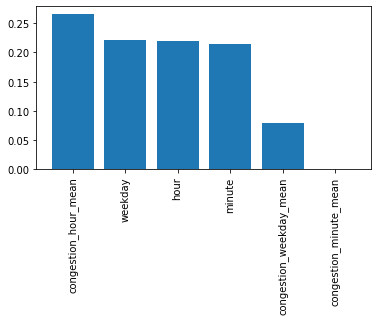

===========(0, 3, 'SW')===========


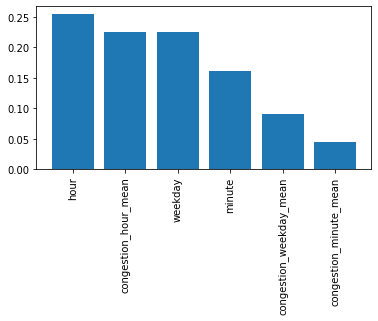

===========(1, 0, 'EB')===========


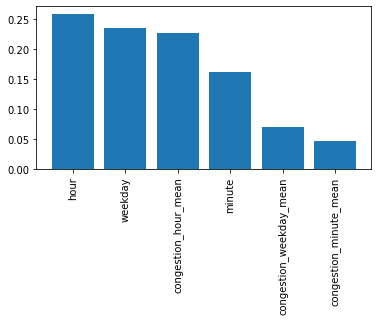

===========(1, 0, 'NB')===========


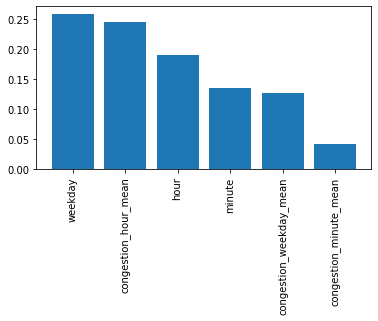

===========(1, 0, 'SB')===========


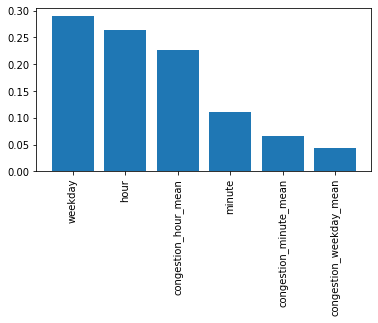

===========(1, 0, 'WB')===========


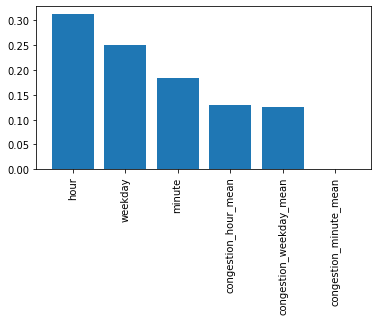

===========(1, 0, 'NE')===========


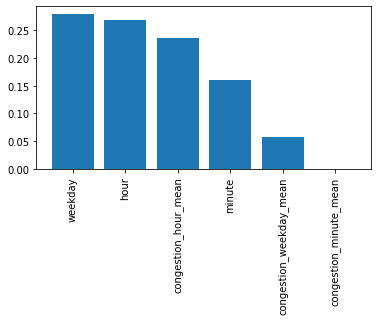

===========(1, 0, 'SW')===========


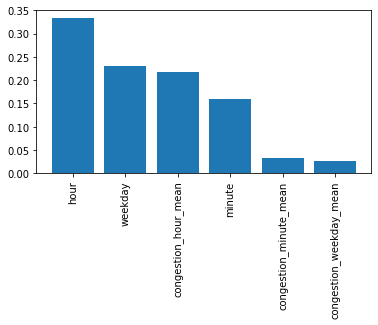

===========(1, 1, 'EB')===========


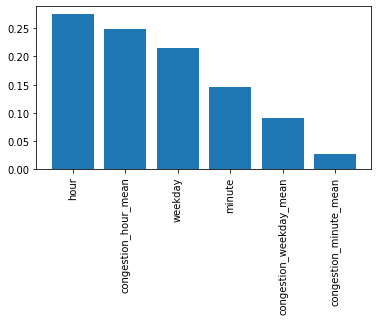

===========(1, 1, 'NB')===========


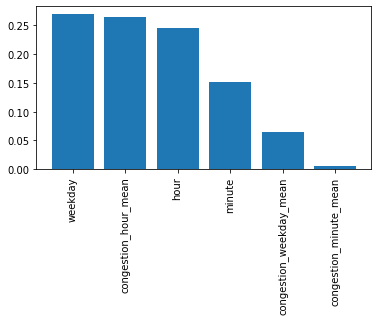

===========(1, 1, 'SB')===========


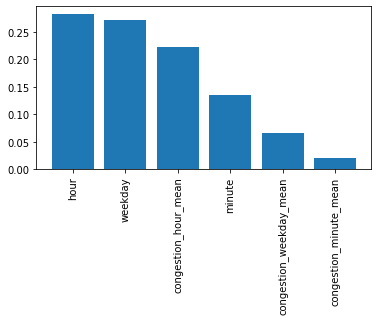

===========(1, 1, 'WB')===========


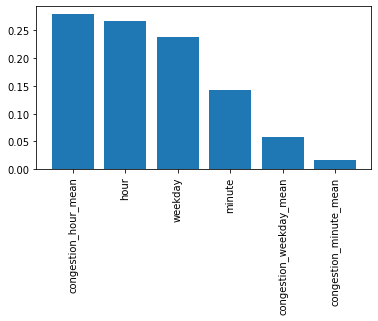

===========(1, 2, 'EB')===========


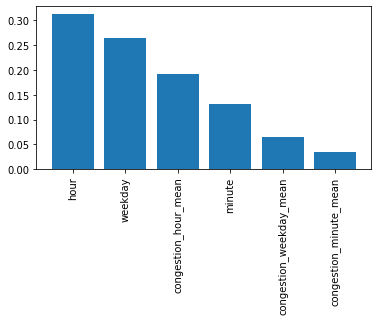

===========(1, 2, 'NB')===========


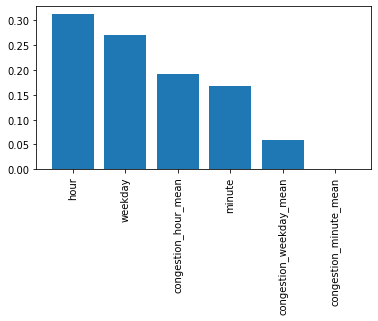

===========(1, 2, 'SB')===========


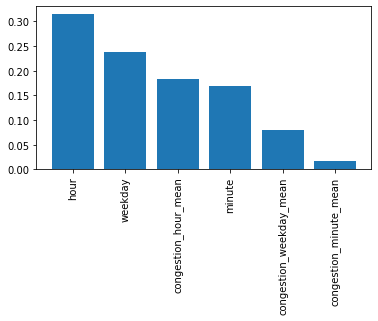

===========(1, 2, 'WB')===========


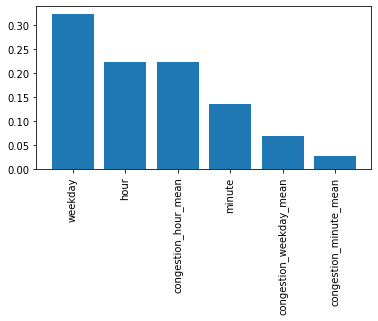

===========(1, 2, 'NE')===========


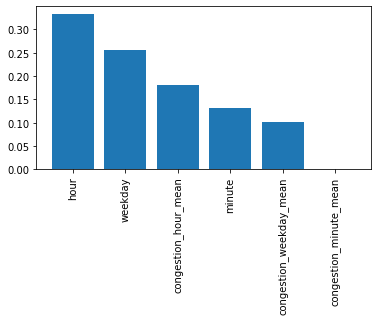

===========(1, 2, 'SW')===========


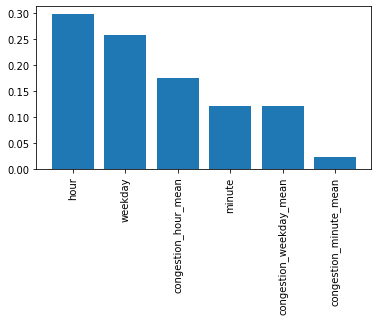

===========(1, 3, 'EB')===========


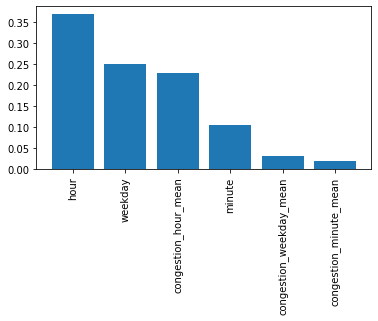

===========(1, 3, 'NB')===========


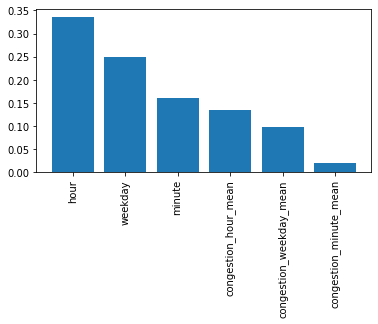

===========(1, 3, 'SB')===========


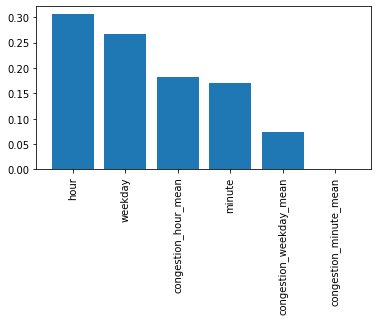

===========(1, 3, 'WB')===========


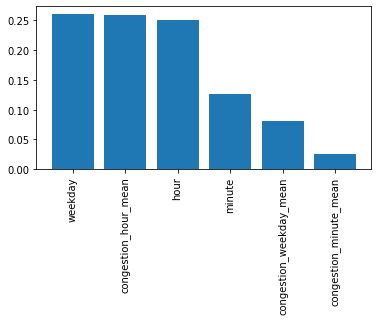

===========(1, 3, 'NE')===========


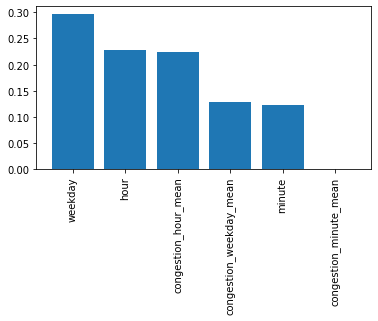

===========(1, 3, 'SW')===========


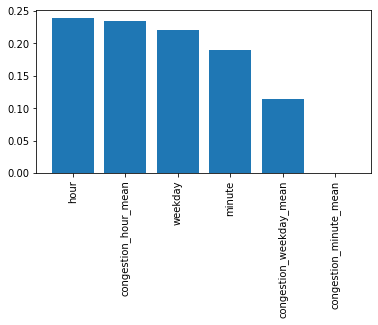

===========(2, 0, 'EB')===========


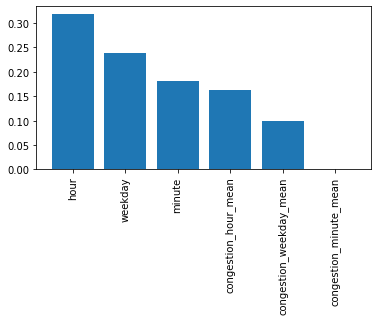

===========(2, 0, 'NB')===========


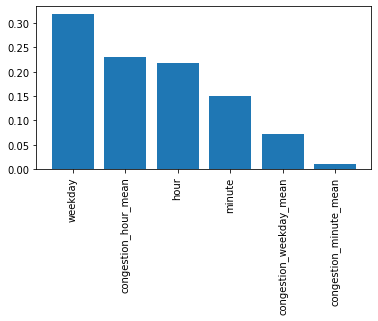

===========(2, 0, 'SB')===========


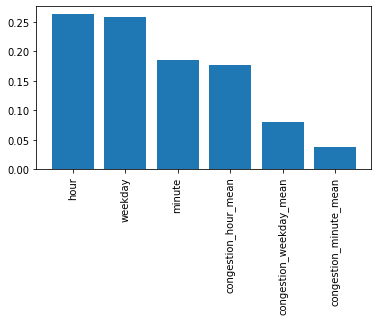

===========(2, 0, 'WB')===========


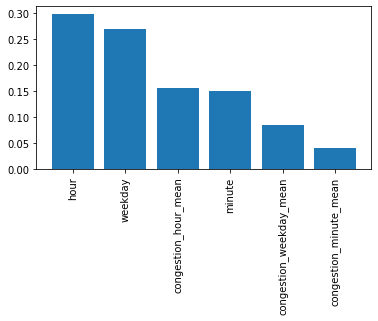

===========(2, 1, 'EB')===========


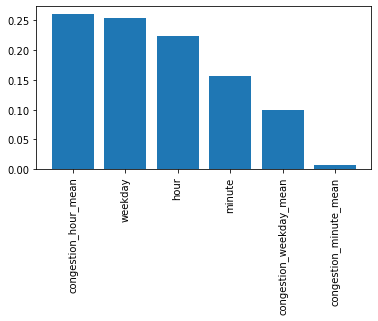

===========(2, 1, 'NB')===========


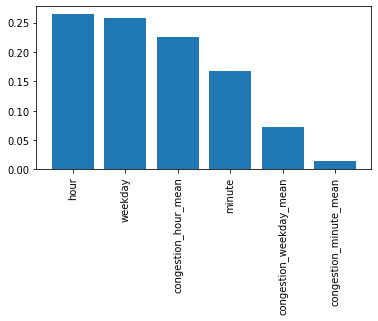

===========(2, 1, 'SB')===========


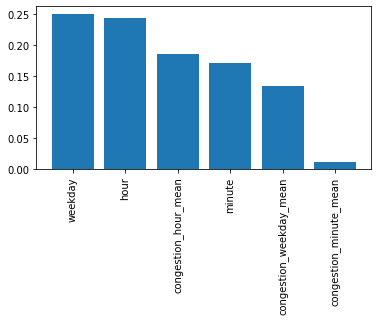

===========(2, 1, 'WB')===========


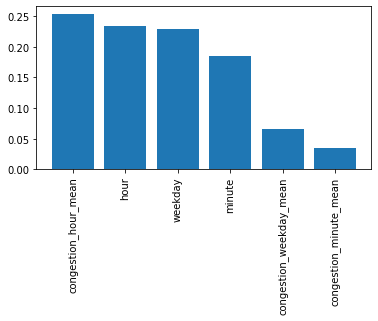

===========(2, 1, 'NE')===========


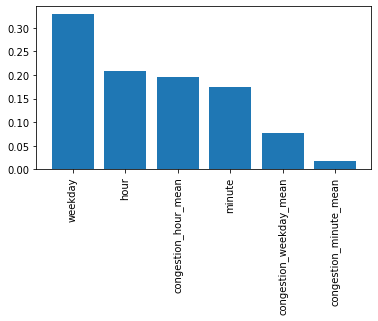

===========(2, 1, 'SW')===========


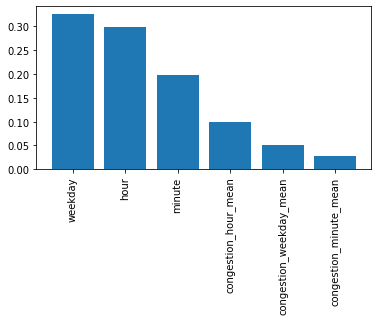

===========(2, 1, 'NW')===========


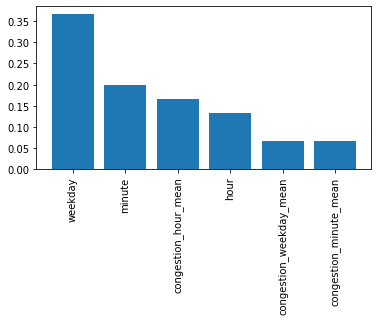

===========(2, 1, 'SE')===========


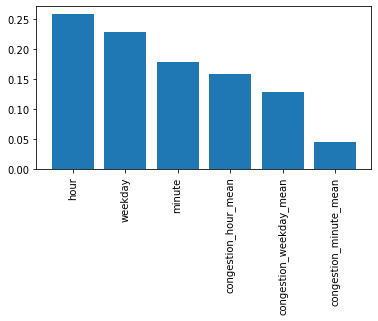

===========(2, 2, 'EB')===========


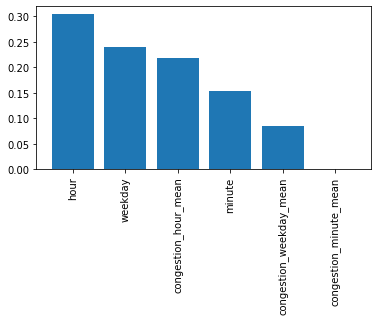

===========(2, 2, 'NB')===========


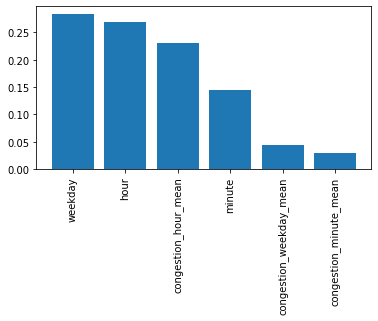

===========(2, 2, 'SB')===========


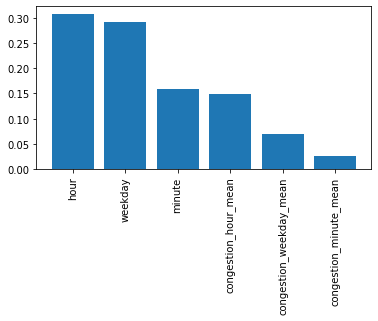

===========(2, 2, 'WB')===========


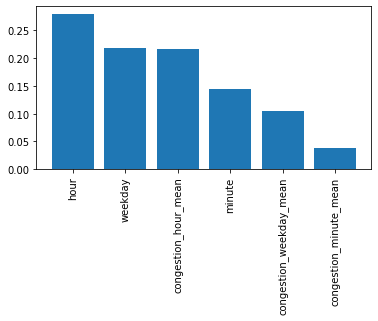

===========(2, 2, 'NE')===========


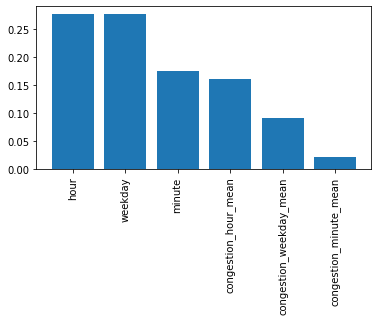

===========(2, 2, 'SW')===========


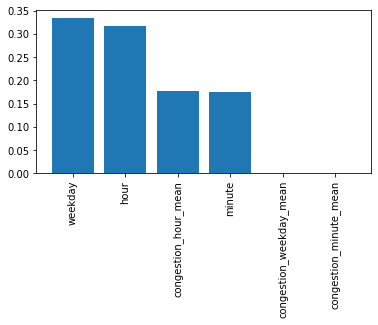

===========(2, 2, 'NW')===========


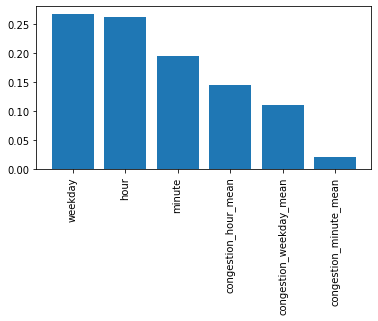

===========(2, 2, 'SE')===========


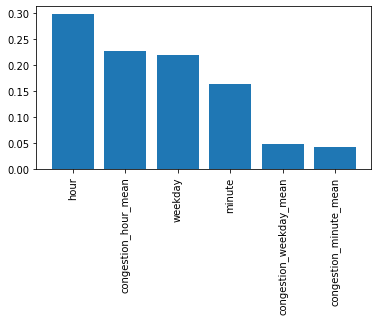

===========(2, 3, 'EB')===========


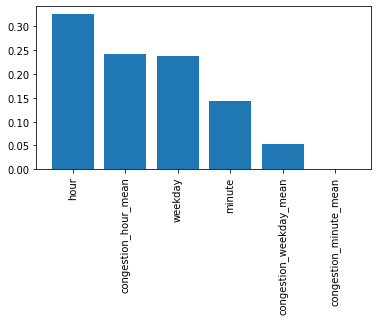

===========(2, 3, 'NB')===========


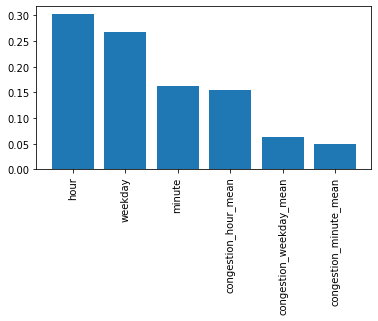

===========(2, 3, 'SB')===========


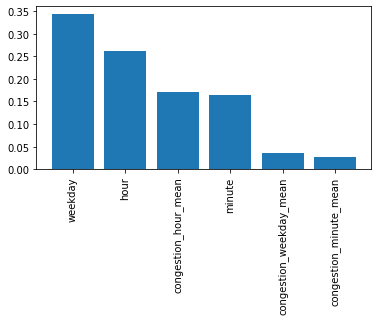

===========(2, 3, 'WB')===========


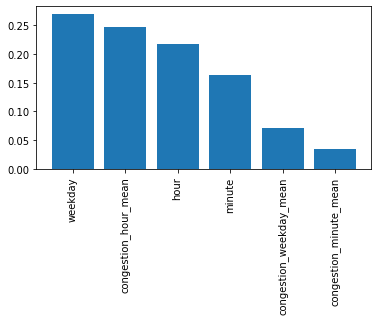

===========(2, 3, 'NE')===========


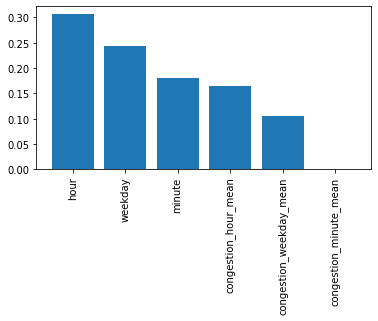

===========(2, 3, 'SW')===========


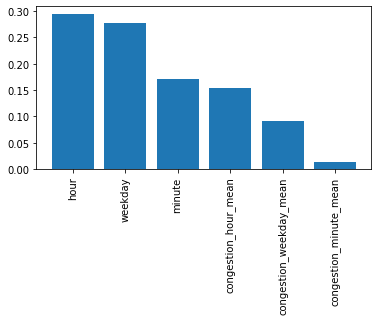

In [55]:
for key, models in all_models.items():
    f_importance = models[-1].feature_importance()
    f_importance = f_importance / sum(f_importance)
    df_importance = pd.DataFrame({"feature": feature_col, "importance": f_importance}).sort_values("importance", ascending=False)
    print("==========={}===========".format(key))
    plt.figure(figsize=(6, 3))
    plt.bar(x="feature", height="importance", data=df_importance)
    plt.xticks(rotation=90)
    plt.show()

### submit

In [ ]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

In [ ]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_007.csv -m "007"